In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

Using TensorFlow backend.


In [2]:
#gdax = quandl.get('GDAX/USD', returns='pandas')

#kraken = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
#kraken["Weighted Price"][:1032]

#gdax["WP"] = (gdax["Open"][0] + gdax["High"][0] + gdax["Low"][0])/3

data.head()


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [3]:
#for i in range(0,1032):
    #gdax["WP"][i] = (gdax["Open"][i] + gdax["High"][i] + gdax["Low"][i])/3
    

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
#taking weighted volume and volumeC and next days weighted to predict 

values = reframed.values
n_train_hours = int(len(values) * 0.75)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
look_back = 1

# reshape input to be 3D [samples, timesteps, features]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
predictDates = data.tail(len(testX)).index

1070
357


In [5]:
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.055728,0.000715,0.000129,0.055496
2,0.055496,0.000878,0.000157,0.054838
3,0.054838,0.000373,0.000066,0.055998
4,0.055998,0.000367,0.000066,0.059966
5,0.059966,0.000858,0.000163,0.057344


In [6]:
model = Sequential()
model.add(LSTM(150,dropout=0.1 ,return_state=False,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(64, activation='linear'))
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1071 samples, validate on 358 samples
Epoch 1/300
1071/1071 [==============================] - 1s 845us/step - loss: 0.0160 - val_loss: 0.2147
Epoch 2/300
1071/1071 [==============================] - 0s 79us/step - loss: 0.0147 - val_loss: 0.1989
Epoch 3/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0128 - val_loss: 0.1958
Epoch 4/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0119 - val_loss: 0.1848
Epoch 5/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0121 - val_loss: 0.1726
Epoch 6/300
1071/1071 [==============================] - 0s 76us/step - loss: 0.0114 - val_loss: 0.1652
Epoch 7/300
1071/1071 [==============================] - 0s 76us/step - loss: 0.0112 - val_loss: 0.1573
Epoch 8/300
1071/1071 [==============================] - 0s 79us/step - loss: 0.0109 - val_loss: 0.1500
Epoch 9/300
1071/1071 [==============================] - 0s 80us/step - loss: 0.0106 - val_loss: 0.1428
Epoch 10/300
107

1071/1071 [==============================] - 0s 79us/step - loss: 0.0038 - val_loss: 0.0144
Epoch 79/300
1071/1071 [==============================] - 0s 76us/step - loss: 0.0048 - val_loss: 0.0161
Epoch 80/300
1071/1071 [==============================] - 0s 73us/step - loss: 0.0049 - val_loss: 0.0094
Epoch 81/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0044 - val_loss: 0.0201
Epoch 82/300
1071/1071 [==============================] - 0s 71us/step - loss: 0.0062 - val_loss: 0.0350
Epoch 83/300
1071/1071 [==============================] - 0s 71us/step - loss: 0.0045 - val_loss: 0.0217
Epoch 84/300
1071/1071 [==============================] - 0s 69us/step - loss: 0.0033 - val_loss: 0.0119
Epoch 85/300
1071/1071 [==============================] - 0s 70us/step - loss: 0.0032 - val_loss: 0.0114
Epoch 86/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0034 - val_loss: 0.0118
Epoch 87/300
1071/1071 [==============================] - 0s 70us/st

1071/1071 [==============================] - 0s 76us/step - loss: 0.0051 - val_loss: 0.0348
Epoch 156/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0042 - val_loss: 0.0251
Epoch 157/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0035 - val_loss: 0.0145
Epoch 158/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0035 - val_loss: 0.0103
Epoch 159/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0045 - val_loss: 0.0091
Epoch 160/300
1071/1071 [==============================] - 0s 71us/step - loss: 0.0040 - val_loss: 0.0152
Epoch 161/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0035 - val_loss: 0.0279
Epoch 162/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0051 - val_loss: 0.0391
Epoch 163/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0047 - val_loss: 0.0274
Epoch 164/300
1071/1071 [==============================] - 0

1071/1071 [==============================] - 0s 67us/step - loss: 0.0055 - val_loss: 0.0402
Epoch 233/300
1071/1071 [==============================] - 0s 65us/step - loss: 0.0041 - val_loss: 0.0277
Epoch 234/300
1071/1071 [==============================] - 0s 65us/step - loss: 0.0037 - val_loss: 0.0170
Epoch 235/300
1071/1071 [==============================] - 0s 76us/step - loss: 0.0035 - val_loss: 0.0110
Epoch 236/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0041 - val_loss: 0.0105
Epoch 237/300
1071/1071 [==============================] - 0s 74us/step - loss: 0.0033 - val_loss: 0.0204
Epoch 238/300
1071/1071 [==============================] - 0s 75us/step - loss: 0.0029 - val_loss: 0.0292
Epoch 239/300
1071/1071 [==============================] - 0s 76us/step - loss: 0.0049 - val_loss: 0.0390
Epoch 240/300
1071/1071 [==============================] - 0s 72us/step - loss: 0.0043 - val_loss: 0.0257
Epoch 241/300
1071/1071 [==============================] - 0

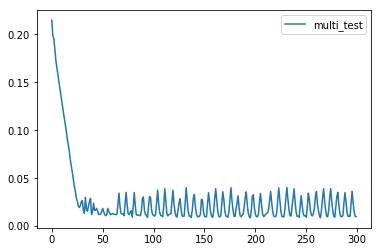

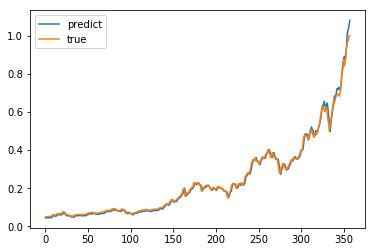

In [7]:

pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()



In [8]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 166.537


In [9]:

actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
py.iplot([ multi_predict_chart, actual_chart])

In [10]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.055728,0.000715,0.000129,0.055496
2,0.055496,0.000878,0.000157,0.054838
3,0.054838,0.000373,0.000066,0.055998
4,0.055998,0.000367,0.000066,0.059966
5,0.059966,0.000858,0.000163,0.057344


In [12]:
from keras.models import load_model

model.save('166RMSE_model.h5')  # creates a HDF5 file 'my_model.h5'

#model = load_model('my_model.h5')

In [15]:
gdax = quandl.get('GDAX/USD', returns='pandas')
gdax.head()

,Open,High,Low,Volume
Date,,,,
2014-12-01,300.00,370.0,300.0,0.056556
2014-12-02,377.00,378.0,377.0,15.013600
2014-12-03,377.01,378.0,377.9,0.546608
2014-12-04,377.10,377.1,377.1,0.010000
2014-12-06,378.00,378.0,378.0,0.015000


In [33]:
#(train_X.shape[1], train_X.shape[2]) # (1, 3)
gdax = quandl.get('GDAX/USD', returns='pandas')
gdax["WP"] = (gdax["Open"][0] + gdax["High"][0] + gdax["Low"][0])/3
for i in range(0,1033):
    gdax["WP"][i] = (gdax["Open"][i] + gdax["High"][i] + gdax["Low"][i])/3
gdax.tail()


,Open,High,Low,Volume,WP
Date,,,,,
2017-12-03,10986.09,11891.00,10601.00,30475.693967,11159.363333
2017-12-04,11219.99,11589.98,10950.00,20402.240408,11253.323333
2017-12-05,11511.49,11875.00,11511.02,18115.797692,11632.503333
2017-12-06,11780.01,14425.00,11713.00,46998.131614,12639.336667
2017-12-07,14327.00,19697.00,13500.00,86811.070025,15841.333333


In [34]:
gdax = go.Scatter(x=gdax.index, y=gdax['WP'], name= 'Price')
py.iplot([gdax])

In [64]:
gdax = quandl.get('GDAX/USD', returns='pandas')
gdax["WP"] = (gdax["Open"][0] + gdax["High"][0] + gdax["Low"][0])/3
for i in range(0,1033):
    gdax["WP"][i] = (gdax["Open"][i] + gdax["High"][i] + gdax["Low"][i])/3
gdax.head()

,Open,High,Low,Volume,WP
Date,,,,,
2014-12-01,300.00,370.0,300.0,0.056556,323.333333
2014-12-02,377.00,378.0,377.0,15.013600,377.333333
2014-12-03,377.01,378.0,377.9,0.546608,377.636667
2014-12-04,377.10,377.1,377.1,0.010000,377.100000
2014-12-06,378.00,378.0,378.0,0.015000,378.000000


In [65]:
gdax.drop(gdax.columns[[0]],axis=1,inplace=True)
gdax["tomHIGH"] = gdax["High"][1]
gdax.head()

,High,Low,Volume,WP,tomHIGH
Date,,,,,
2014-12-01,370.0,300.0,0.056556,323.333333,378.0
2014-12-02,378.0,377.0,15.013600,377.333333,378.0
2014-12-03,378.0,377.9,0.546608,377.636667,378.0
2014-12-04,377.1,377.1,0.010000,377.100000,378.0
2014-12-06,378.0,378.0,0.015000,378.000000,378.0


In [66]:
for i in range(1032):
    gdax["tomHIGH"][i] = gdax["High"][i+1]
gdax.head()

,High,Low,Volume,WP,tomHIGH
Date,,,,,
2014-12-01,370.0,300.0,0.056556,323.333333,378.00
2014-12-02,378.0,377.0,15.013600,377.333333,378.00
2014-12-03,378.0,377.9,0.546608,377.636667,377.10
2014-12-04,377.1,377.1,0.010000,377.100000,378.00
2014-12-06,378.0,378.0,0.015000,378.000000,375.01


In [67]:
gdax.tail()

,High,Low,Volume,WP,tomHIGH
Date,,,,,
2017-12-03,11891.00,10601.00,30475.693967,11159.363333,11589.98
2017-12-04,11589.98,10950.00,20402.240408,11253.323333,11875.00
2017-12-05,11875.00,11511.02,18115.797692,11632.503333,14425.00
2017-12-06,14425.00,11713.00,46998.131614,12639.336667,19697.00
2017-12-07,19697.00,13500.00,86811.070025,15841.333333,378.00


In [68]:
gdax.drop(gdax.tail(1).index,inplace=True) # drop last row
gdax.tail()

,High,Low,Volume,WP,tomHIGH
Date,,,,,
2017-12-02,11100.00,10701.00,20655.110024,10879.373333,11891.00
2017-12-03,11891.00,10601.00,30475.693967,11159.363333,11589.98
2017-12-04,11589.98,10950.00,20402.240408,11253.323333,11875.00
2017-12-05,11875.00,11511.02,18115.797692,11632.503333,14425.00
2017-12-06,14425.00,11713.00,46998.131614,12639.336667,19697.00


In [71]:
train_gdaxx = np.array(gdax[gdax.columns[0:4]])
train_gdaxy = np.array(gdax["tomHIGH"])
model = Sequential()
model.add(LSTM(150,dropout=0.1 ,return_state=False,input_shape=(train_X.shape[1], 4)))
#model.add(Dense(64, activation='linear'))
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')
#multi_history = model.fit(train_gdaxx, train_gdaxy, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [72]:
model.fit(train_gdaxx,train_gdaxy,epochs=300,batch_size=100)

ValueError: Error when checking input: expected lstm_3_input to have 3 dimensions, but got array with shape (1032, 4)